In [2]:
# test reading in 10x data with AnnData
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob
import os
import scvi
import pickle
from scipy import sparse
import anndata as ad
import itertools

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("whitegrid")

from matplotlib.ticker import StrMethodFormatter
# ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

import requests
from tqdm import tqdm

data_dir = "data"

c:\Users\randymi\anaconda3\envs\scanpy-env\Lib\site-packages\scvi\__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(5, 3), facecolor="white")

c:\Users\randymi\anaconda3\envs\scanpy-env\Lib\site-packages\scanpy\_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [8]:
# run once
with open("combined_hs_counts.pkl", "rb") as file:
    hs_combined = pickle.load(file)

# filter out to just the desired datasets
df = pd.read_excel('sample_list.xlsx')
GSMs = list(df['GSM'][df['Using']])

filtered_hs_counts = hs_combined[hs_combined.obs['GSM'].apply(lambda x: 'GSM'+str(x) in GSMs)]
filtered_hs_counts.obs.index = ['cell_' + str(i) for i in range(filtered_hs_counts.n_obs)]
filtered_hs_counts.obs['GSM'] = filtered_hs_counts.obs['GSM'].astype('category')

filtered_hs_counts.X = filtered_hs_counts.X.astype(int)

#with open("filtered_hs_counts.pkl", "wb") as file:
#    pickle.dump(filtered_hs_counts, file)
    
filtered_hs_counts.write_h5ad("filtered_hs_counts.h5ad")

C:\Users\randymi\AppData\Local\Temp\ipykernel_1832\3540739713.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  filtered_hs_counts.obs['GSM'] = filtered_hs_counts.obs['GSM'].astype('category')


In [74]:
def plot_umap(hs_combined, filename, hue = "batch"):
    fig, ax = plt.subplots(figsize = (10,10))
    uc = hs_combined.obsm['X_umap']
    sns.scatterplot(x = uc[:,0], y = uc[:,1], hue = hs_combined.obs[hue], legend = "full", s = 2, ax = ax)
    ax.set_title(filename)
    ax.legend(markerscale = 5)
    fig.savefig("figures" + '/' + filename + '.png', dpi = 300)
    plt.close()

In [78]:
# plot umaps for each of the three GSEs

def gse_umap(adata, batch, harmony = True):
    temp = adata[adata.obs['batch'] == batch]

    sc.pp.highly_variable_genes(
        temp,
        flavor = "seurat_v3",
        n_top_genes = 3000,
        # inplace subset
        subset = True
    )

    sc.pp.regress_out(temp, ["pct_counts_mt"])
    sc.pp.scale(temp, max_value = 10)
    sc.pp.pca(temp)
    
    if harmony:
        sc.external.pp.harmony_integrate(temp, key = "GSM", basis = 'X_pca')
        sc.pp.neighbors(temp, use_rep = "X_pca_harmony")
        title = "GSE_" + str(batch) + "_harmony"
    else:
        sc.pp.neighbors(temp, use_rep = "X_pca")
        title = "GSE_" + str(batch)

    sc.tl.umap(temp)
    plot_umap(temp, title, hue = "GSM")


In [73]:
list(filtered_hs_counts.obs['batch'].unique())

['220116', '175990', '154775']

In [88]:
for GSE in tqdm(list(filtered_hs_counts.obs['batch'].unique())):
    gse_umap(filtered_hs_counts, GSE)
    gse_umap(filtered_hs_counts, GSE, harmony = False)

c:\Users\randymi\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
2024-08-06 02:37:10,010 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-06 02:37:10,963 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-06 02:37:11,018 - harmonypy - INFO - Iteration 1 of 10
2024-08-06 02:37:13,608 - harmonypy - INFO - Iteration 2 of 10
2024-08-06 02:37:16,285 - harmonypy - INFO - Iteration 3 of 10
2024-08-06 02:37:18,906 - harmonypy - INFO - Iteration 4 of 10
2024-08-06 02:37:21,526 - harmonypy - INFO - Iteration 5 of 10
2024-08-06 02:37:24,081 - harmonypy - INFO - Iteration 6 of 10
2024-08-06 02:37:26,615 - harmonypy - INFO - Iteration 7 of 10
2024-08-06 02:37:29,167 - harmonypy - INFO - Converged after 7 iterations
Exception ignored in: <function tqdm.__del__ at 0x000

In [4]:
hs_ad = ad.read_h5ad("filtered_hs_counts.h5ad")
# select highly varied genes
# top genes that overlap
# seurat_v3 expects raw counts
sc.pp.highly_variable_genes(
    hs_ad,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    # inplace subset
    subset = True
)

sc.pp.regress_out(hs_ad, ["pct_counts_mt"])
sc.pp.scale(hs_ad, max_value = 10)
sc.pp.pca(hs_ad)
sc.external.pp.harmony_integrate(hs_ad, key = "GSM", basis = 'X_pca')
sc.pp.neighbors(hs_ad, use_rep = "X_pca_harmony")
sc.tl.umap(hs_ad)

2024-08-06 13:44:49,835 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
c:\Users\randymi\anaconda3\envs\scanpy-env\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2024-08-06 13:44:55,911 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-06 13:44:56,206 - harmonypy - INFO - Iteration 1 of 10
2024-08-06 13:45:21,488 - harmonypy - INFO - Iteration 2 of 10
2024-08-06 13:45:46,670 - harmonypy - INFO - Iteration 3 of 10
2024-08-06 13:46:11,356 - harmonypy - INFO - Iteration 4 of 10
2024-08-06 13:46:36,

In [6]:
hs_ad.write_h5ad("filtered_hs_counts_harmony.h5ad")

In [20]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        hs_ad, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

In [17]:
sc.tl.leiden(hs_ad, resolution = 0.5, key_added = "leiden_res_0.5")
sc.tl.leiden(hs_ad, resolution = 1, key_added = "leiden_res_1")
sc.tl.leiden(hs_ad, resolution = 0.1, key_added = "leiden_res_0.1")
sc.tl.leiden(hs_ad, resolution = 0.2, key_added = "leiden_res_0.2")



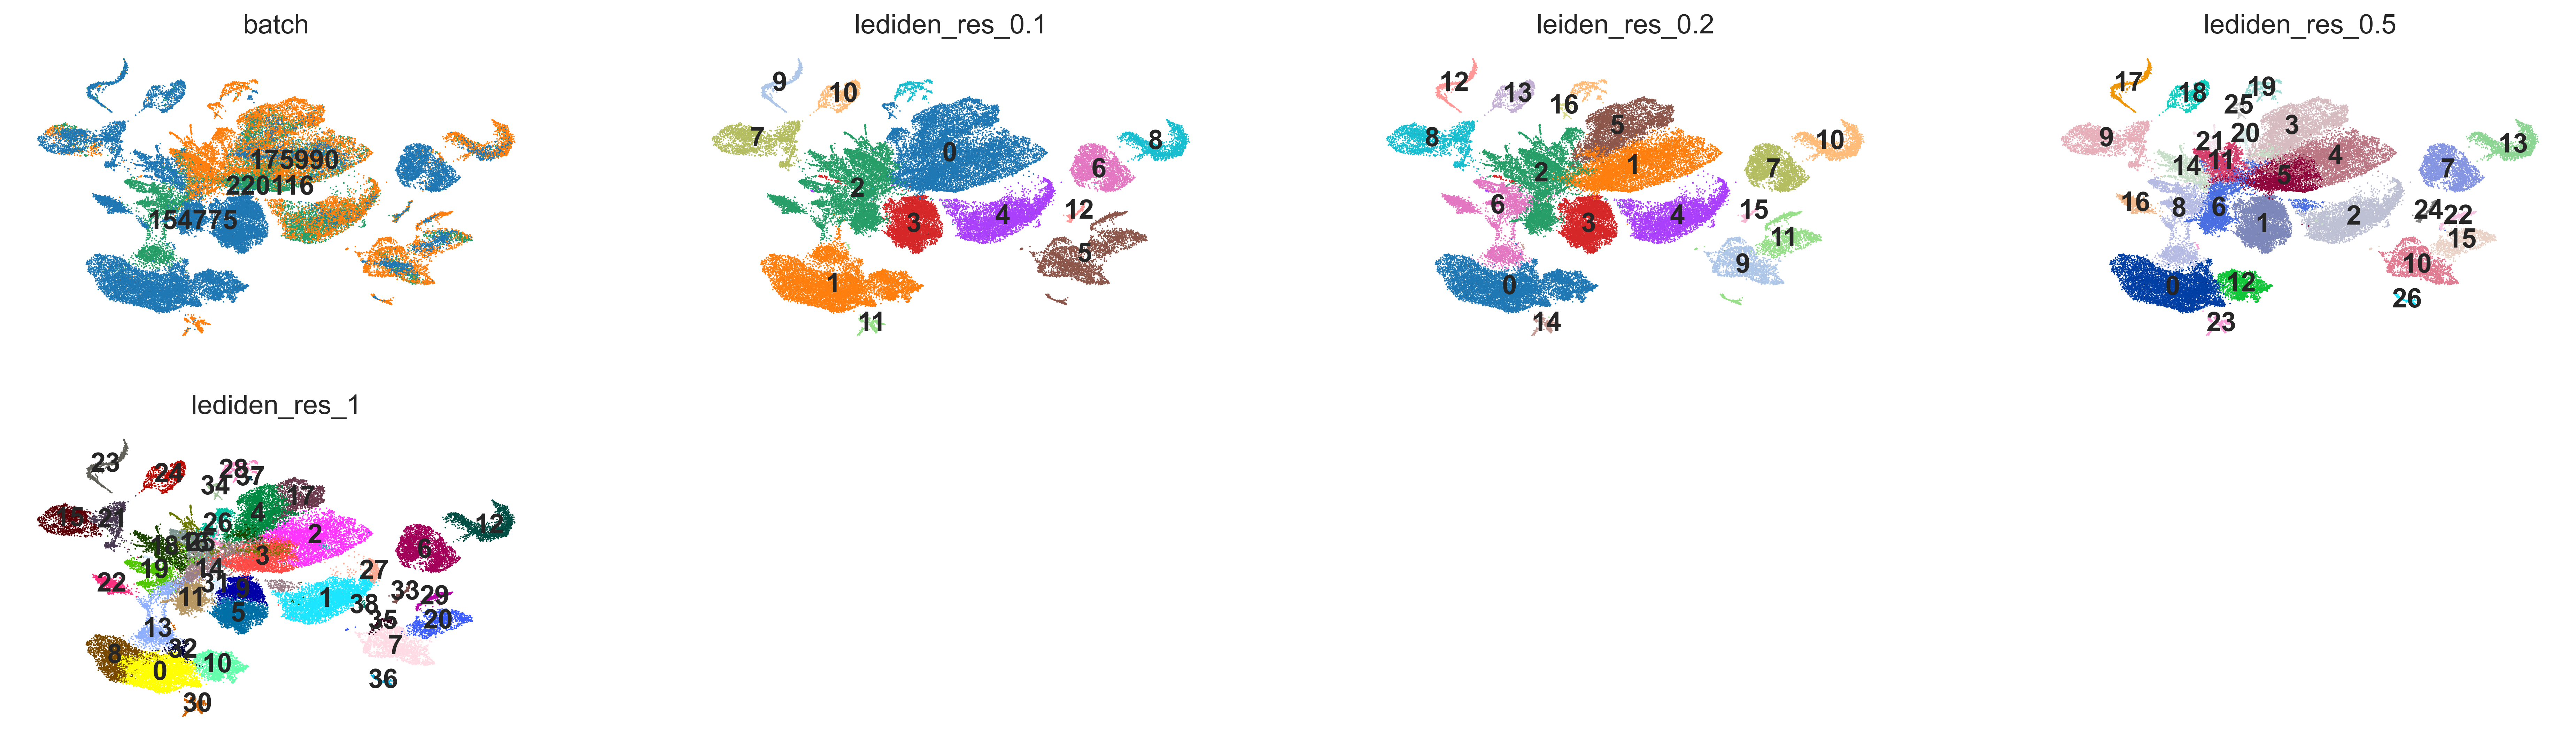

In [18]:
sc.pl.umap(hs_ad, color = ["batch","lediden_res_0.1", "leiden_res_0.2", "lediden_res_0.5", "lediden_res_1"], legend_loc = "on data")

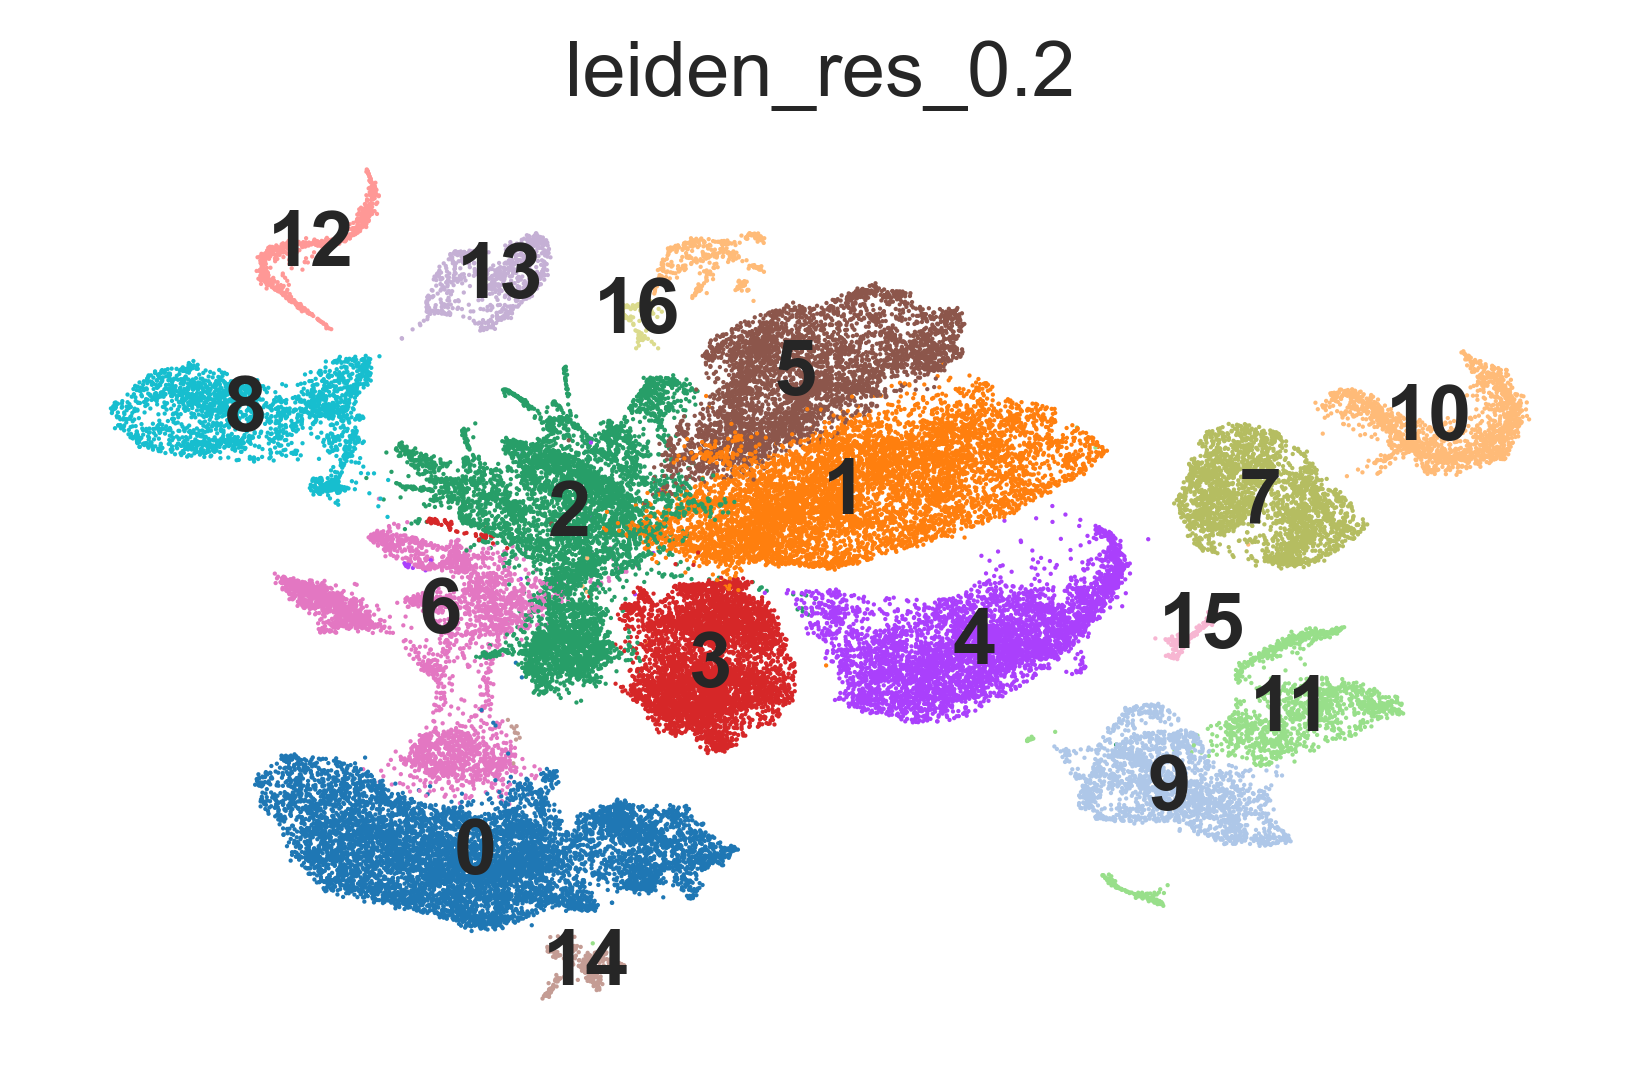

In [174]:
sc.pl.umap(hs_ad, color = ["leiden_res_0.2"], legend_loc = "on data")

In [ ]:
# map ENSG to symbol

from Ensembl_converter import EnsemblConverter

# Create an instance of EnsemblConverter
converter = EnsemblConverter()
batch_size = 20

for i in tqdm(range(0,hs_ad.n_vars, batch_size)):
    
    # first iter
    if i == 0:
        gene_names = converter.convert_ids(hs_ad.var_names[i:i + batch_size])
        continue

    if (i + batch_size) > hs_ad.n_vars:
        temp = converter.convert_ids(hs_ad.var_names[i:hs_ad.n_vars])
    else:
        temp = converter.convert_ids(hs_ad.var_names[i:i + batch_size])
    
    gene_names = pd.concat([gene_names, temp])



gene_names.reset_index(inplace= True)

gene_names.drop(['index'], axis = 1, inplace = True)
def grch37_name(ENS):
    try:
        server = "https://grch37.rest.ensembl.org"
        ext = f"/lookup/id/{ENS}?expand=1"
        
        r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
        
        decoded = r.json()
        return decoded['display_name']
    except:
        return ENS
# now search up for GRCH37

def replace_grch37(val):
    if val[:4] == "ENSG":
        return grch37_name(val)
    else:
        return val

gene_names = gene_names["Symbol"].apply(replace_grch37)

gene_names['Symbol'] = gene_names['Symbol'].fillna(gene_names['ENSG'])
gene_names.to_csv('gene_names.csv')

In [136]:
gene_names.index = gene_names["ENSG"]

gene_names

ENSG           Symbol
ENSG                                             
ENSG00000000005  ENSG00000000005             TNMD
ENSG00000000938  ENSG00000000938              FGR
ENSG00000000971  ENSG00000000971              CFH
ENSG00000001626  ENSG00000001626             CFTR
ENSG00000002587  ENSG00000002587           HS3ST1
...                          ...              ...
ENSG00000283646  ENSG00000283646        LINC02009
ENSG00000284668  ENSG00000284668        LINC02780
ENSG00000284681  ENSG00000284681  ENSG00000284681
ENSG00000284823  ENSG00000284823  ENSG00000284823
ENSG00000285130  ENSG00000285130  ENSG00000285130

[3000 rows x 2 columns]

In [141]:
# add names to obs
hs_ad.var = hs_ad.var.join(gene_names)
hs_ad.var_names = hs_ad.var['Symbol']
hs_ad.var.index.name = None

categories: 0, 1, 2, etc.
var_group_labels: CD14+ Mono, CD16+ Mono, cDC2, etc.


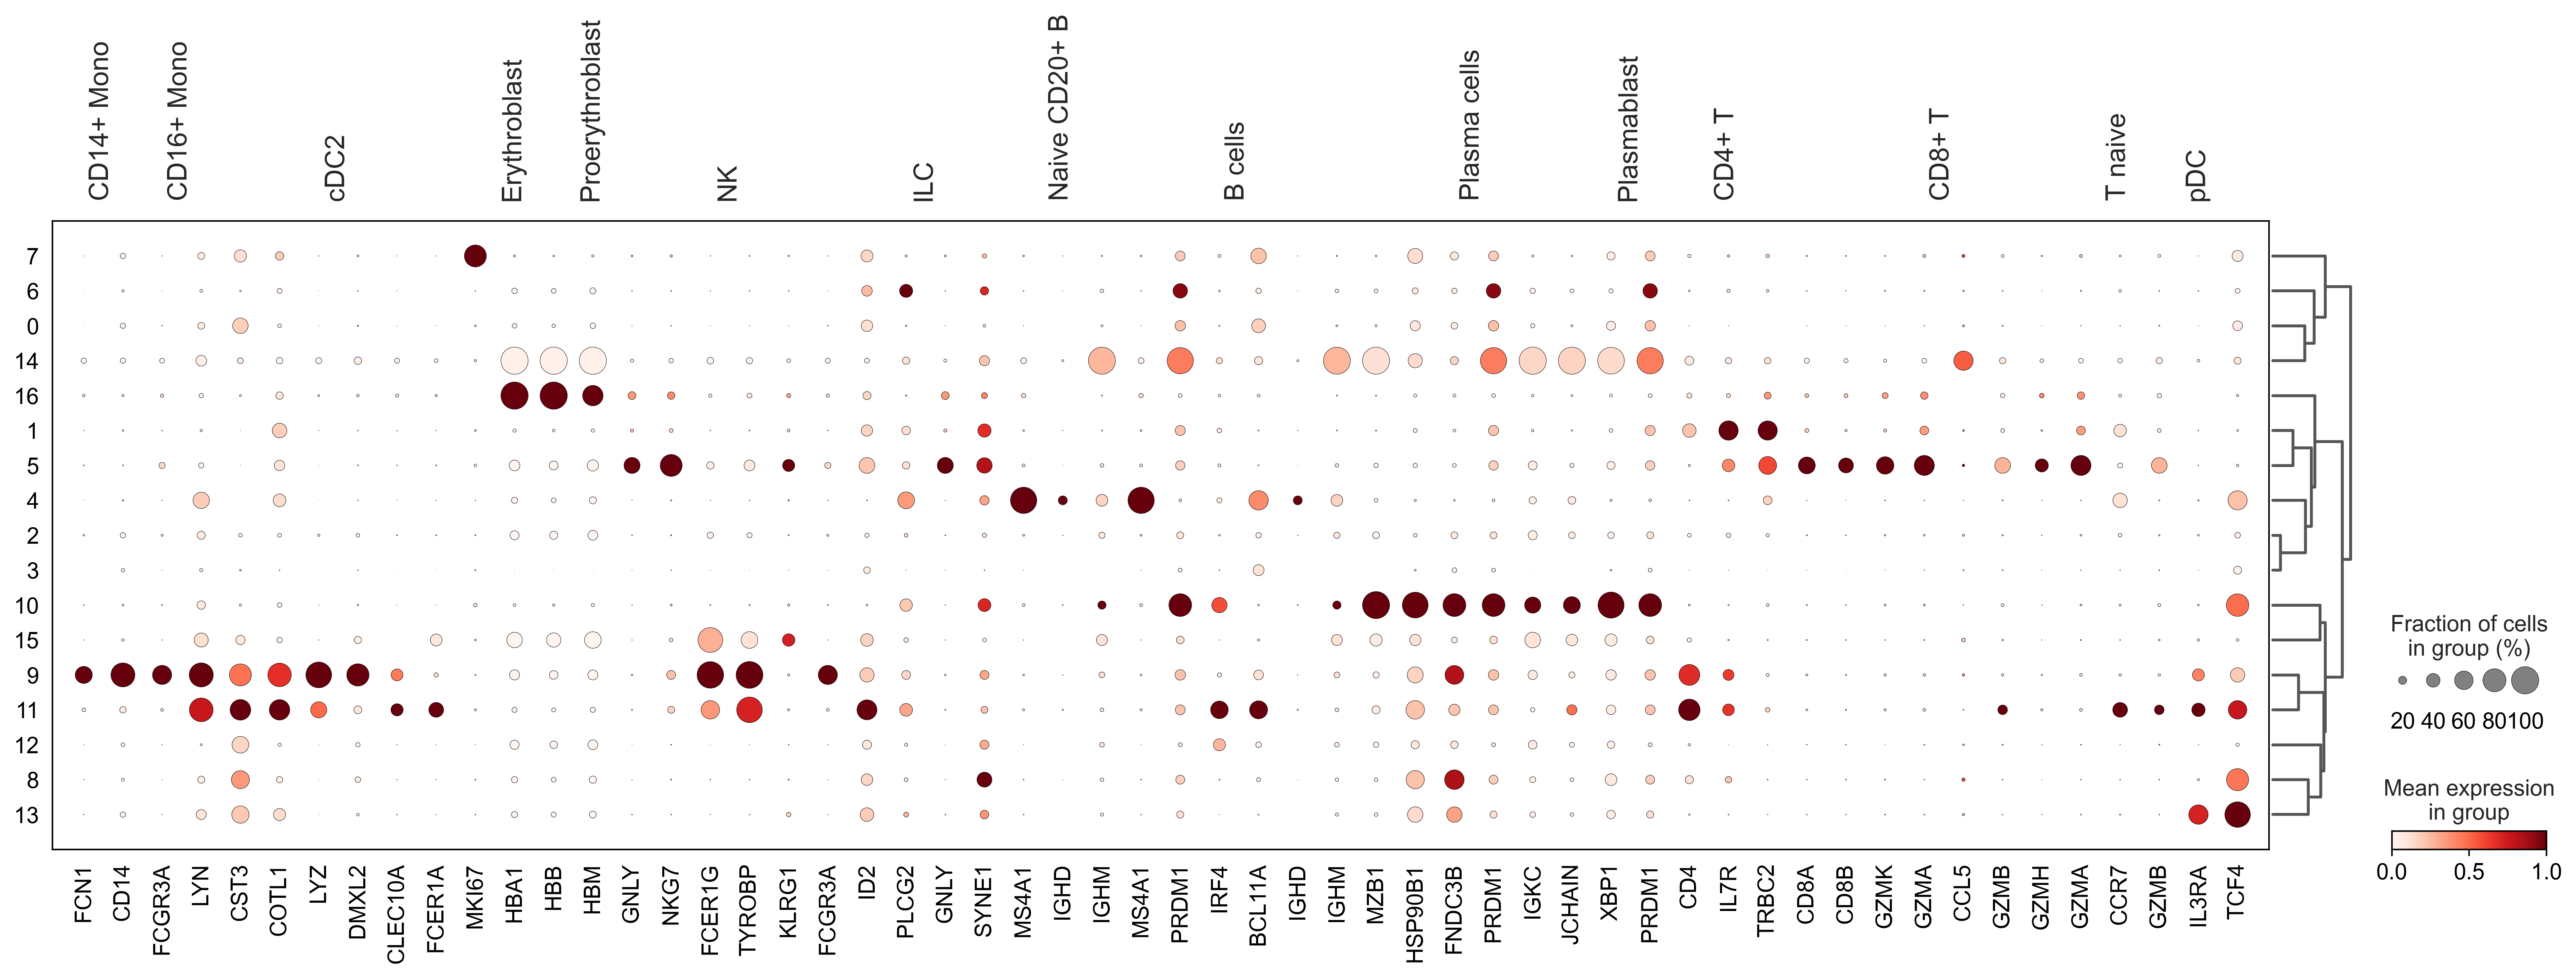

In [176]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["HBM"],
    "NK": ["GNLY", "NKG7", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IGHD", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "PRDM1",
        "IRF4",
        "BCL11A",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["CCR7"],
    "pDC": ["GZMB", "IL3RA", "TCF4"],
}

hs_ad.var_names_make_unique()

sc.pl.dotplot(hs_ad, marker_genes, groupby="leiden_res_0.2", standard_scale="var", dendrogram= True)



In [182]:
hs_ad.write_h5ad("filtered_hs_counts_post.h5ad")